In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [7]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [3]:
os.listdir(os.getcwd()+'/garbage-classification/Garbage classification')

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']

In [4]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n1 = len(os.listdir(folder))
    n0 = 1
    full_set = list(range(n0,n1+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(n0,n1+1)),int(.5*(n1-n0)))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [5]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('garbage-classification/Garbage classification',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [26]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/Users/joseperezcano/Desktop/MamutHack/data')

In [27]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16, num_workers=0)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x12bfd8b70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [28]:
data

ImageDataBunch;

Train: LabelList (1259 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /Users/joseperezcano/Desktop/MamutHack/data;

Valid: LabelList (633 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /Users/joseperezcano/Desktop/MamutHack/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /Users/joseperezcano/Desktop/MamutHack/data

In [9]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


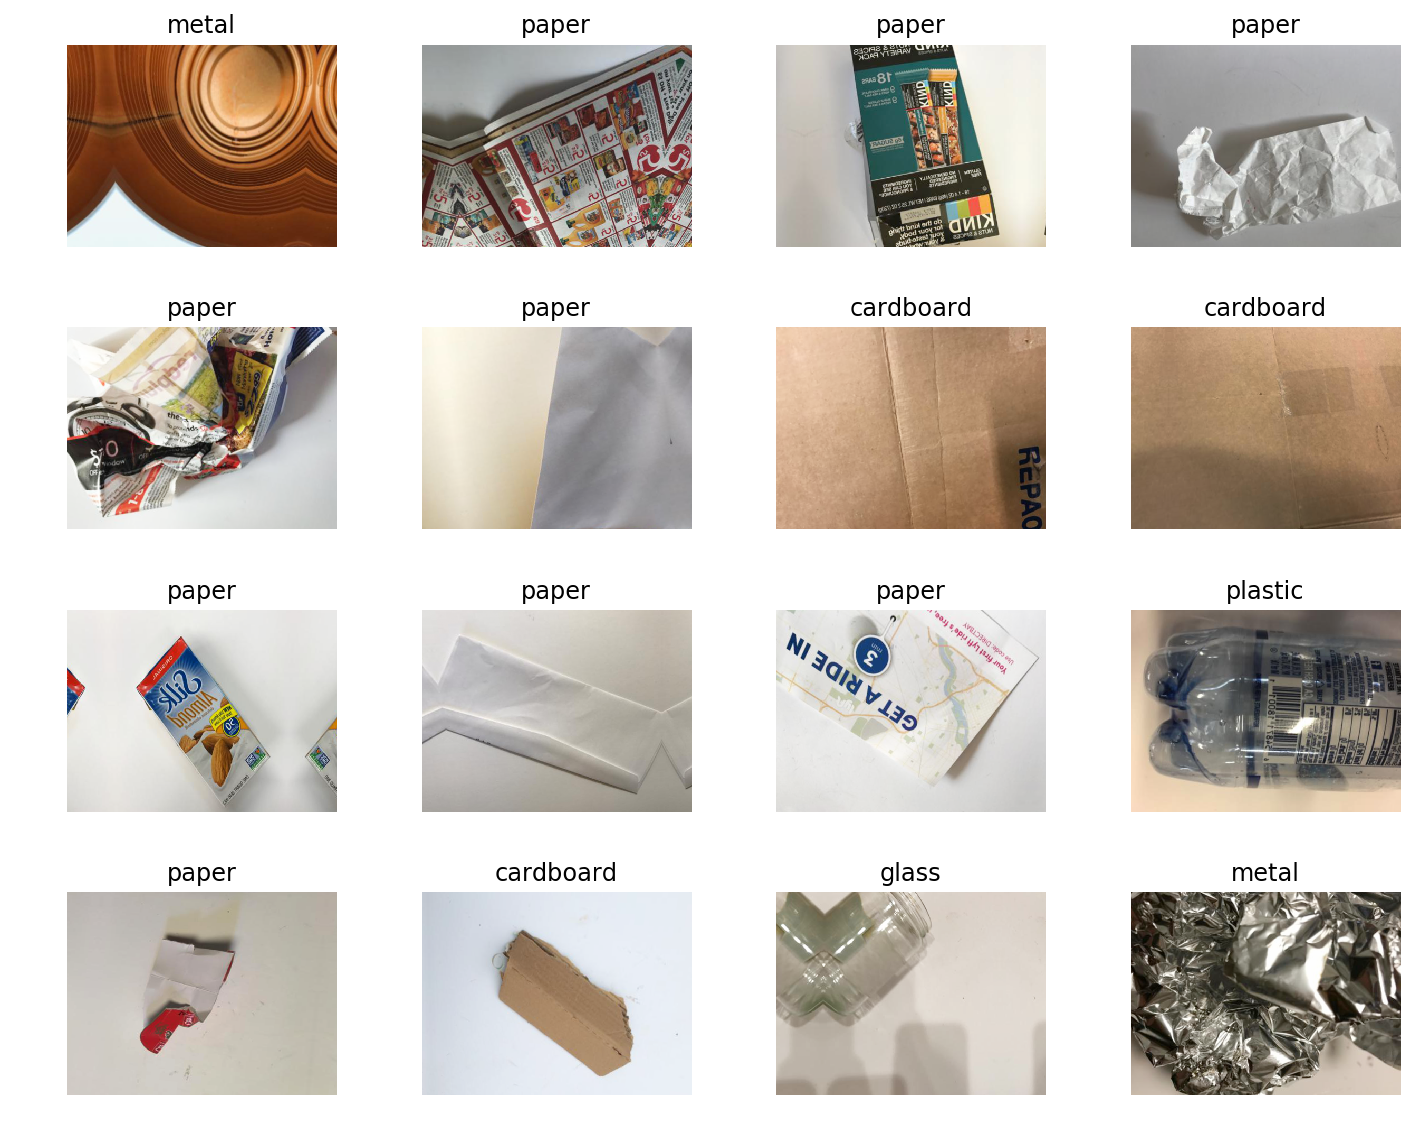

In [10]:
data.show_batch(rows=4,figsize=(10,8))

In [11]:
"""New vs already trained"""
# learn = cnn_learner(data,models.resnet34,metrics=error_rate)
learn = load_learner(Path(os.getcwd())/'app','trained_model.pkl')

In [ ]:
# Train more
"""for i in range(4):  
    learn.fit_one_cycle(5,max_lr=5.13e-03)
    learn.export('5-epoch-('+str(i)+')')"""

epoch,train_loss,valid_loss,error_rate,time
0,1.344202,0.759257,0.211690,25:44
1,1.254744,0.765180,0.246445,25:37
2,0.868023,0.411902,0.131122,26:03
3,0.623188,0.282962,0.094787,25:52
4,0.466223,0.282946,0.105845,25:35


epoch,train_loss,valid_loss,error_rate,time
0,0.440655,0.444052,0.137441,25:58
1,0.786016,0.831690,0.274882,26:00
2,0.738055,0.540841,0.180095,26:01
3,0.550363,0.295682,0.105845,25:59
4,0.337691,0.279448,0.096367,25:59


epoch,train_loss,valid_loss,error_rate,time
0,0.370764,0.404096,0.137441,25:59
1,0.670308,1.255497,0.323855,26:00
2,0.596953,0.620534,0.184834,26:01


In [24]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.7/site-packages/fastai/data_block.py", line 651, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/usr/local/lib/python3.7/site-packages/fastai/data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/usr/local/lib/python3.7/site-packages/fastai/vision/data.py", line 270, in get
    fn = super().get(i)
  File "/usr/local/lib/python3.7/site-packages/fastai/data_block.py", line 75, in get
    return self.items[i]
IndexError: index 0 is out of bounds for axis 0 with size 0


In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

In [25]:
preds = learn.get_preds(ds_type=DatasetType.Test)
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])
    y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

AttributeError: 'NoneType' object has no attribute 'dataset'

In [ ]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

In [ ]:
cm = confusion_matrix(y,yhat)
print(cm)

df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [ ]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]
accuracy = correct/sum(sum(cm))
accuracy

In [22]:
path2 = Path(os.getcwd())/'Ejemplo/cara.jpg'
img = open_image(path2)
preds = learn.predict(img)

In [23]:
str(preds[0])

'paper'